# 导入包

In [1]:
import pandas as pd
import os
import sys
import shutil
import numpy as np
import re
import csv
import math
import pickle
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import MaxNLocator

Looking in indexes: https://pypi.tuna.tsinghua.edu.cn/simple
     ---------------------------------------- 0.0/7.8 MB ? eta -:--:--
     ---------- ----------------------------- 2.1/7.8 MB 10.7 MB/s eta 0:00:01
     -------------------- ------------------- 3.9/7.8 MB 9.4 MB/s eta 0:00:01
     -------------------------------- ------- 6.3/7.8 MB 10.2 MB/s eta 0:00:01
     ---------------------------------------- 7.8/7.8 MB 10.1 MB/s eta 0:00:00
     ---------------------------------------- 0.0/2.2 MB ? eta -:--:--
     ---------------------------------------- 2.2/2.2 MB 11.3 MB/s eta 0:00:00
  Using cached https://pypi.tuna.tsinghua.edu.cn/packages/ea/2b/7fc9f4e7ae5b507c1a3a21f0f15ed03e794c1242ea8a242ac158beb56034/numpy-2.0.2-cp39-cp39-win_amd64.whl (15.9 MB)
     ---------------------------------------- 0.0/2.6 MB ? eta -:--:--
     ------------------------------------ --- 2.4/2.6 MB 10.3 MB/s eta 0:00:01
     ---------------------------------------- 2.6/2.6 MB 10.5 MB/s eta 0:00:00
  U

  You can safely remove it manually.


In [ ]:
# 读取CSV文件，因为第一行也是数据，所以header=None
df1 = pd.read_csv('csdmof.csv', header=None, names=['NameUpper', 'Data1'])
df2 = pd.read_csv('CO2csd.csv', header=None, names=['nameLower', 'Data2', 'Data3'])

# 将第一个DataFrame的'NameUpper'转成小写，使其能与第二个DataFrame的'nameLower'匹配
df1['nameLower'] = df1['NameUpper'].str.lower()

# 按照'NameLower'列进行合并
merged_df = pd.merge(df1, df2, on='nameLower')

# 保存结果到新的CSV文件
merged_df.to_csv('merged_file.csv', index=False)

In [ ]:
merged_df.columns

In [ ]:
pdf_folder_path = "NewPDFs"

if 'Data6' not in merged_df.columns:
    merged_df['Data6'] = None

count = 1

for doi in merged_df["Data1"]:
    line = doi.strip()
    new_line = line.replace('/', '-').replace(":", '-').replace("<", '-').replace(">", '-')
    symbol = 0
    for target_string in os.listdir(pdf_folder_path):
        if new_line in target_string:
            symbol = 1
            merged_df.loc[merged_df['Data1'] == doi, 'Data6'] = target_string
            break
        elif target_string[:-4].upper() in new_line:
            symbol = 1
            merged_df.loc[merged_df['Data1'] == doi, 'Data6'] = target_string
    if symbol == 0:
        merged_df.loc[merged_df['Data1'] == doi, 'Data6'] = None
    count += symbol

In [ ]:
# 统计Data6列中非None（或非NaN）值的数量
non_none_count = merged_df['Data6'].notna().sum()

print(f"Number of non-None values in Data6: {non_none_count}")

In [ ]:
pdf_folder_path = "./scalable"

if 'Data7' not in merged_df.columns:
    merged_df['Data7'] = None

count = 0


for doi in merged_df["Data6"]:
    if doi == None:
        pass
    else:
        line = doi[:-4]+".txt"
        scalable_txt = os.path.join(pdf_folder_path, line)
        try:
            with open(scalable_txt, mode="r") as file:
                # 用于存储提取的数字
                numbers = []
                for line in file:
                    # 使用正则表达式查找所有数字（包括浮点数）
                    found_numbers = re.findall(r'-?\d+\.?\d*', line)
                    
                    # 将找到的数字字符串转换为浮点数并添加到列表中
                    numbers.extend([float(num) for num in found_numbers])
                if len(numbers) == 0:
                    merged_df.loc[merged_df['Data6'] == doi, 'Data7'] = None
                elif len(numbers) == 1:
                    count += 1
                    merged_df.loc[merged_df['Data6'] == doi, 'Data7'] = numbers[0]
                elif len(numbers) > 1:
                    count += 1
                    merged_df.loc[merged_df['Data6'] == doi, 'Data7'] = numbers[0]
        except:
            pass

In [ ]:
# 统计Data6列中非None（或非NaN）值的数量
non_none_count = merged_df['Data7'].notna().sum()

print(f"Number of non-None values in Data6: {non_none_count}")

In [ ]:
merged_df.to_csv("./merged.csv", index=False)

### Charge

In [ ]:
# 金属元素
metal_element = ['Li', 'Be', 'Na', 'Mg', 'Al', 'K', 'Ca', 'Sc', 'Ti', 'V', 'Cr', 'Mn', 'Fe', 'Co', 'Ni', 'Cu', 'Zn',
                 'Ga', 'Ge', 'Rb', 'Sr', 'Y', 'Zr', 'Nb', 'Mo', 'Tc', 'Ru', 'Rh', 'Pd', 'Ag', 'Cd', 'In', 'Sn',
                 'Sb',
                 'Cs', 'Ba', 'La', 'Ce', 'Pr', 'Nd', 'Pm', 'Sm', 'Eu', 'Gd', 'Tb', 'Dy', 'Ho', 'Er', 'Tm', 'Yb',
                 'Lu',
                 'Hf', 'Ta', 'W', 'Re', 'Os', 'Ir', 'Pt', 'Au', 'Hg', 'Tl', 'Pb', 'Bi', 'Po', 'Fr', 'Ra', 'Ac']

f = open("./statistical_result_file.csv", mode="w", encoding="utf-8",
         newline="")
statistical_result_file = csv.writer(f)
# statistical_result_file.writerow(["name",'metal', 'mean', 'fangcha'])
for file_name in os.listdir("./CSD_Charge"):
    with open(f"./CSD_Charge/{file_name}", mode="r") as cif:
        first_metal = ""
        first_metal_num = []
        second_metal = ""
        second_metal_num = []
        for line in cif:
            test = line.split(" ")
            test = [i for i in test if i != '']
            try:
                if len(test) > 2:
                    if test[-2] in metal_element:
                        # print(test[-2])
                        if first_metal == "":
                            first_metal = test[-2]
                            first_metal_num.append(float(test[-1]))
                        elif test[-2] == first_metal:
                            first_metal_num.append(float(test[-1]))
                        elif test[-2] != first_metal and first_metal != "" and second_metal == "":
                            second_metal = line.split("  ")[-2]
                            second_metal_num.append(float(test[-1]))
                        elif test[-2] == second_metal:
                            second_metal_num.append(float(test[-1]))
            except:
                print(test[-2])
        print(first_metal_num)
        try:
            average_first = sum(first_metal_num) / len(first_metal_num)
            rms_first = math.sqrt(sum([x ** 2 for x in first_metal_num]) / len(first_metal_num))
            statistical_result_file.writerow([file_name, first_metal, len(first_metal_num), average_first, rms_first])
        except:
            pass

        # print(f"{file_name},{first_metal},{len(first_metal_num)},{second_metal},{len(second_metal_num)}")


In [ ]:
f.close()

In [ ]:
pd1 = pd.read_csv("./statistical_result_file.csv",header=None, names=["ID","Metal","num","Charge","rms"])

metal_index = ["ID", "Cu", "Zr", "Hf", "In", "Eu", "Zn", "Mg", "Co", "Ni", "Cd", "Cr", "Tb", "Sm", "Y", "Nd", "Pb",
               "Sr", "Ce", "Tm", "Yb", "Ho", "Ca", "Gd", "Er", "K", "Fe", "first_metal", "second_metal","Coordination carboxyl", "Triazole", "Benzene ring", "Naphthalene", "Triazine", "Pyrazole",
                    "NN double bond", "Pyridine", "Piperazine", "Amino", "CO double bond", "Phenol hydroxyl",
                    "CC triple bond", "Tetrazole", "Imidazole", "Nitro group", "CN double bond", "Fluorine ion",
                    "Sulfone", "CC double bond", "Porphyrin", "Anthracene", "Carboxyl", "Iodine ion", "Bromine ion","TBAB","TBAC","TBAI","pore","surface area","SO","PO","BO","ECH","EBP","Catalyst Loading","Substrate","Time","Temperature","Pressure"]
pd2 = pd.DataFrame(index=[x for x in range(0, pd1.shape[0])], columns=metal_index, data=0.0)
pd2['ID'].update(pd1['ID'])

for i in range(pd2.shape[0]):
    try:
        if pd1.loc[i,"Metal"] in metal_index:
            pd2.loc[i, pd1.loc[i,"Metal"]] = 1
            pd2.loc[i, "first_metal"] = pd1.loc[i, "Charge"]
            pd2.loc[i, "second_metal"] = pd1.loc[i, "Charge"]
            pd2.loc[i, "Coordination carboxyl"] = 1
            pd2.loc[i, "Benzene ring"] = 1
            pd2.loc[i, "ECH"] = 1
            pd2.loc[i, "Temperature"] = 80
            pd2.loc[i, "Pressure"] = 1
            pd2.loc[i, "TBAB"] = 5
            pore_path = "./tobacco/"+pd2.loc[i,"ID"]+".vol"
            surface_path = "./tobacco/"+pd2.loc[i,"ID"]+".sa"
            
            with open(f"/tobacco/{pd2.loc[i,"ID"]}.vol", 'r') as data:
                data_read = data.read()
                list = data_read.split(' ')
                pd2.loc[i, "pore"] = list[13]
    
            with open(f"/tobacco/{pd2.loc[i,"ID"]}.sa", 'r') as data:
                data_read = data.read()
                list = data_read.split(' ')
                pd2.loc[i, "pore"] = list[15]
    except:
        pass
        
    list2 = str(pd2.loc[i, "ID"]).split("_")
    for a in list2:
        if a in list(pd2.columns):
            pd2.loc[i, a] = 1

In [ ]:
pd2.to_csv("to_predict.csv")

In [1]:
import pandas as pd
import pickle
pd_to_predict = pd.read_csv("./to_predict2.csv")
X_predict = pd_to_predict.iloc[:, 2:]
X_predict.drop(["Catalyst Loading", "Time", "Substrate"], axis=1, inplace=True)

In [2]:
X_predict

,Cu,Zr,Hf,In,Eu,Zn,Mg,Co,Ni,Cd,...,TBAI,pore,surface area,SO,PO,BO,ECH,EBP,Temperature,Pressure
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,80,1


In [3]:
result_pd2 = pd.DataFrame(index=[x for x in range(0, pd_to_predict.shape[0])], columns=["ID"], data=0.0)
result_pd2["ID"] = pd_to_predict["ID"]
with open("./RF_51.595982145.pickle", "rb") as model:
    clf = pickle.load(model)
    Y_predict = clf.predict(X_predict)
    Y_predict_proba = clf.predict_proba(X_predict)
    result_pd2[f"Y_predict"] = Y_predict
    result_pd2[f"Y_predict_proba"] = Y_predict_proba[:, 1]
result_pd2.to_csv("./Result.csv")

F:\Software\Anaconda3\Lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.1.3 when using version 1.5.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


ValueError: node array from the pickle has an incompatible dtype:
- expected: {'names': ['left_child', 'right_child', 'feature', 'threshold', 'impurity', 'n_node_samples', 'weighted_n_node_samples', 'missing_go_to_left'], 'formats': ['<i8', '<i8', '<i8', '<f8', '<f8', '<i8', '<f8', 'u1'], 'offsets': [0, 8, 16, 24, 32, 40, 48, 56], 'itemsize': 64}
- got     : [('left_child', '<i8'), ('right_child', '<i8'), ('feature', '<i8'), ('threshold', '<f8'), ('impurity', '<f8'), ('n_node_samples', '<i8'), ('weighted_n_node_samples', '<f8')]

In [4]:
merged_pd2 = pd.read_csv("./merged.csv")
merged_df = pd.read_csv("./Result.csv")

In [5]:
for i in range(merged_df.shape[0]):
    data = merged_df.loc[i,"ID"]
    merged_df.loc[i,"nameLower"] = data.split("_")[0]

In [7]:
merged_df_final = pd.merge(merged_pd2, merged_df, on='nameLower')

In [8]:
merged_df_final.to_csv("./result_final.csv")

In [47]:
merged_df_final = pd.read_csv("./result_final.csv")

In [48]:
merged_df_final

,Unnamed: 0,NameUpper,Data1,nameLower,Data2,Data3,Data6,Data7,ID,Y_predict,Y_predict_proba
0,1864,HICTIZ,10.1039/C8DT01185K,hictiz,99.788400,37.320321,10.1039-C8DT01185K_1729003791321406_spirkl2018...,53.600000,hictiz_P1_charged.cif,False,0.149926
1,9086,OGESOJ,10.1016/j.jssc.2008.02.018,ogesoj,92.226452,8.538058,10.1016-j.jssc.2008.02.018_1729222234379804_ch...,250.000000,ogesoj_P1_charged_H_charged.cif,False,0.149926
2,10727,BEDHOJ,10.1002/cssc.201100702,bedhoj,73.701508,5.214843,10.1002-cssc.201100702.pdf,300.000000,bedhoj_P1_charged.cif,False,0.050889
3,1488,WUZGOQ,10.1039/D0CE00979B,wuzgoq,72.630598,4.881533,10.1039-D0CE00979B_1729003220607321_10.1039@d0...,97.653812,wuzgoq_P1_charged.cif,False,0.058889
4,9916,PARMIG,10.1007/s11426-011-4321-z,parmig,65.742722,3.414318,10.1007-s11426-011-4321-z_1728999672915944_wu2...,30.000000,parmig_P1_charged.cif,False,0.050889
...,...,...,...,...,...,...,...,...,...,...,...
11909,11905,QALNIA,10.1002/1521-3749(200012)626:12<2441::AID-ZAAC...,qalnia,0.000000,0.000000,10.1002-1521-3749(200012)626-12-2441--AID-ZAAC...,NaN,qalnia_P1_H_charged.cif,False,0.211481
11910,11915,HEDGUS,10.1002/(SICI)1521-3773(19990115)38:1/2<140::A...,hedgus,0.000000,0.000000,10.1002-(SICI)1521-3773(19990115)38-1-2-140--A...,1.000000,hedgus_P1_charged.cif,False,0.077037
11911,11260,RIVDEH,10.1002/asia.201301298,rivdeh,NaN,NaN,10.1002-asia.201301298.pdf,624.945881,rivdeh_P1_charged.cif,False,0.067778
11912,11660,LAFRIV,10.1002/anie.201004781,lafriv,NaN,NaN,10.1002-anie.201004781.pdf,637.263398,lafriv_P1_charged.cif,False,0.081111


In [49]:
filtered_df = merged_df_final.dropna(subset=["nameLower", 'Data2', 'Data7', 'Y_predict_proba'])

In [50]:
# 定义一个函数来进行归一化
def normalize_column(column):
    return (column - column.min()) / (column.max() - column.min()) * 100

# 对每一列应用归一化函数
filtered_df['column1_normalized'] = normalize_column(filtered_df['Data2'])
filtered_df['column2_normalized'] = normalize_column(filtered_df['Data7'])
filtered_df['column3_normalized'] = normalize_column(filtered_df['Y_predict_proba'])
filtered_df

C:\Users\Administrator\AppData\Local\Temp\ipykernel_58192\1578159339.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['column1_normalized'] = normalize_column(filtered_df['Data2'])
C:\Users\Administrator\AppData\Local\Temp\ipykernel_58192\1578159339.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['column2_normalized'] = normalize_column(filtered_df['Data7'])
C:\Users\Administrator\AppData\Local\Temp\ipykernel_58192\1578159339.py:8: SettingWithCopyWarning: 
A value is trying to

,Unnamed: 0,NameUpper,Data1,nameLower,Data2,Data3,Data6,Data7,ID,Y_predict,Y_predict_proba,column1_normalized,column2_normalized,column3_normalized
0,1864,HICTIZ,10.1039/C8DT01185K,hictiz,99.788400,37.320321,10.1039-C8DT01185K_1729003791321406_spirkl2018...,53.600000,hictiz_P1_charged.cif,False,0.149926,100.000000,0.315001,22.146481
1,9086,OGESOJ,10.1016/j.jssc.2008.02.018,ogesoj,92.226452,8.538058,10.1016-j.jssc.2008.02.018_1729222234379804_ch...,250.000000,ogesoj_P1_charged_H_charged.cif,False,0.149926,92.422017,1.470298,22.146481
2,10727,BEDHOJ,10.1002/cssc.201100702,bedhoj,73.701508,5.214843,10.1002-cssc.201100702.pdf,300.000000,bedhoj_P1_charged.cif,False,0.050889,73.857791,1.764417,0.951173
3,1488,WUZGOQ,10.1039/D0CE00979B,wuzgoq,72.630598,4.881533,10.1039-D0CE00979B_1729003220607321_10.1039@d0...,97.653812,wuzgoq_P1_charged.cif,False,0.058889,72.784611,0.574142,2.663285
4,9916,PARMIG,10.1007/s11426-011-4321-z,parmig,65.742722,3.414318,10.1007-s11426-011-4321-z_1728999672915944_wu2...,30.000000,parmig_P1_charged.cif,False,0.050889,65.882129,0.176177,0.951173
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11903,11261,FEWQIJ,10.1002/asia.201300250,fewqij,0.000000,0.000000,10.1002-asia.201300250.pdf,90.200000,fewqij_P1_H_charged.cif,False,0.149926,0.000000,0.530296,22.146481
11904,11262,FEWQOP,10.1002/asia.201300250,fewqop,0.000000,0.000000,10.1002-asia.201300250.pdf,90.200000,fewqop_P1_H_charged.cif,False,0.229259,0.000000,0.530296,39.124921
11905,11328,KIMMAY,10.1002/anie.202303561,kimmay,0.000000,0.000000,10.1002-anie.202303561.pdf,627.206053,kimmay_P1_H_charged.cif,False,0.149926,0.000000,3.689164,22.146481
11908,11756,NELWIL,10.1002/anie.200600976,nelwil,0.000000,0.000000,10.1002-anie.200600976.pdf,642.683249,nelwil_P1_charged.cif,False,0.077037,0.000000,3.780207,6.547242


In [51]:
filtered_df['column4'] = filtered_df['column1_normalized'] + filtered_df['column2_normalized'] + filtered_df['column3_normalized']

C:\Users\Administrator\AppData\Local\Temp\ipykernel_58192\2559764829.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['column4'] = filtered_df['column1_normalized'] + filtered_df['column2_normalized'] + filtered_df['column3_normalized']


In [52]:
filtered_df.to_csv("normalized.csv")

In [3]:
filtered_df = pd.read_csv("normalized.csv")

In [5]:
# 归一化 column4 的值到0-100的范围
min_value = filtered_df['column4'].min()
max_value = filtered_df['column4'].max()
filtered_df['column4_normalized'] = (filtered_df['column4'] - min_value) / (max_value - min_value) * 100

In [7]:
# 计算排名百分比
def calculate_rank_percentage(value, column):
    return len(filtered_df[filtered_df[column] >= value])

NameError: name 'ax' is not defined

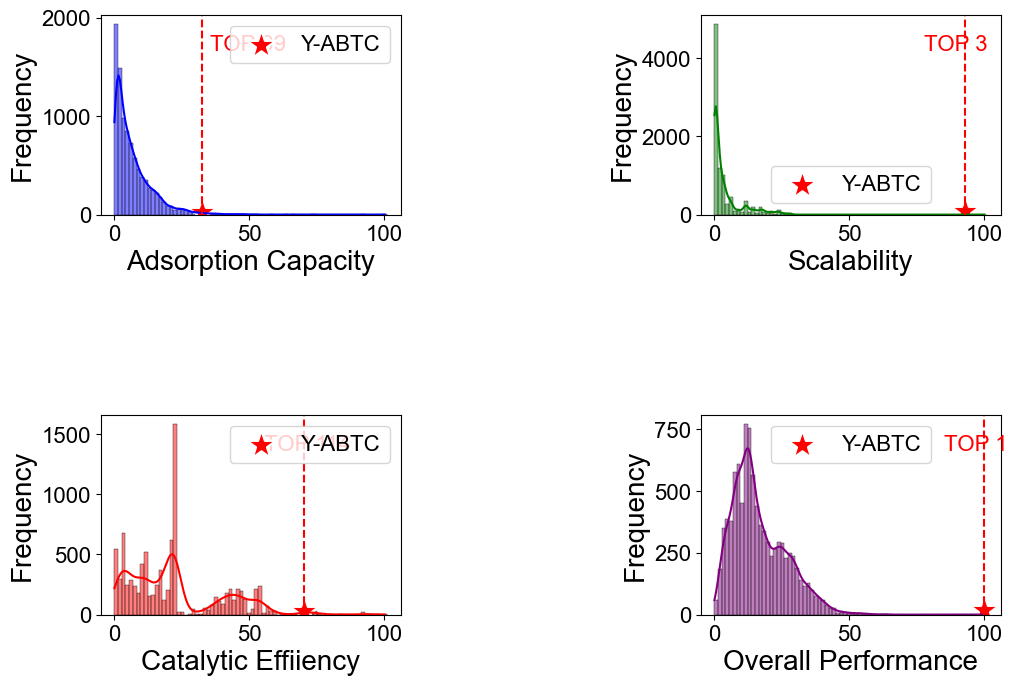

In [9]:
plt.rcParams['font.size'] = 16
plt.rcParams['font.family'] = "Arial"
plt.rcParams['font.style'] = "normal"
# 设置图形大小
plt.figure(figsize=(15, 10))

custom_bins = np.linspace(start=0, stop=101, num=75)
plt.subplots_adjust(left=0.2, right=0.8, bottom=0.2, top=0.8, wspace=1, hspace=1)
# 创建子图布局，这里我们创建2行2列的子图
ax1 = plt.subplot(2, 2, 1)
ax2 = plt.subplot(2, 2, 2)
ax3 = plt.subplot(2, 2, 3)
ax4 = plt.subplot(2, 2, 4)


# 绘制第一列的直方图和密度图
yabtc_df = filtered_df[filtered_df['ID'] == 'YABTC']
sns.histplot(filtered_df['column1_normalized'], kde=True, ax=ax1, color="blue", bins=custom_bins)
sns.scatterplot(x=yabtc_df['column1_normalized'], y=30, marker='*', s=500, color='red', label='Y-ABTC', ax=ax1)
value = yabtc_df["column1_normalized"].values[0]
rank_percentage = calculate_rank_percentage(value, "column1_normalized")
ax1.text(value+3, ax1.get_ylim()[1] * 0.9, f'TOP {rank_percentage}', color='red', va='top')
ax1.axvline(x=value, color='red', linestyle='--')
# ax1.set_title('Column 1 Normalized Distribution')
ax1.set_xlabel('Adsorption Capacity', fontsize=20)
ax1.set_ylabel('Frequency', fontsize=20)


# 绘制第二列的直方图和密度图
sns.histplot(filtered_df['column2_normalized'], kde=True, ax=ax2, color='green', bins=custom_bins)
# ax2.set_title('Column 2 Normalized Distribution', fontsize=24)
sns.scatterplot(x=yabtc_df['column2_normalized'], y=100, marker='*', s=500, color='red', label='Y-ABTC', ax=ax2)
value = yabtc_df["column2_normalized"].values[0]
rank_percentage = calculate_rank_percentage(value, "column2_normalized")
ax2.text(value-15, ax2.get_ylim()[1] * 0.9, f'TOP {rank_percentage}', color='red', va='top')
ax2.axvline(x=value, color='red', linestyle='--')
ax2.set_xlabel('Scalability', fontsize=20)
ax2.set_ylabel('Frequency', fontsize=20)

# 绘制第三列的直方图和密度图
sns.histplot(filtered_df['column3_normalized'], kde=True, ax=ax3, color='red', bins=custom_bins)
# ax3.set_title('Column 3 Normalized Distribution')
sns.scatterplot(x=yabtc_df['column3_normalized'], y=30, marker='*', s=500, color='red', label='Y-ABTC', ax=ax3)
value = yabtc_df["column3_normalized"].values[0]
rank_percentage = calculate_rank_percentage(value, "column3_normalized")
ax3.text(value-15, ax3.get_ylim()[1] * 0.9, f'TOP {rank_percentage}', color='red', va='top')
ax3.axvline(x=value, color='red', linestyle='--')
ax3.set_xlabel('Catalytic Effiiency', fontsize=20)
ax3.set_ylabel('Frequency', fontsize=20)

# 绘制第四列的直方图和密度图


sns.histplot(filtered_df['column4_normalized'], kde=True, ax=ax4, color='purple', bins=custom_bins)
# ax4.set_title('Column 4')
sns.scatterplot(x=yabtc_df['column4_normalized'], y=20, marker='*', s=500, color='red', label='Y-ABTC', ax=ax4)
value = yabtc_df["column4_normalized"].values[0]
rank_percentage = calculate_rank_percentage(value, "column4_normalized")
ax4.text(value-15, ax4.get_ylim()[1] * 0.9, f'TOP {rank_percentage}', color='red', va='top')
ax4.axvline(x=value, color='red', linestyle='--')
ax4.set_xlabel('Overall Performance', fontsize=20)
ax4.set_ylabel('Frequency', fontsize=20)

# 调整子图边框的粗细
ax.spines['top'].set_linewidth(2)  # 上边框
ax.spines['bottom'].set_linewidth(2)  # 下边框
ax.spines['left'].set_linewidth(2)  # 左边框
ax.spines['right'].set_linewidth(2)
# 调整子图之间的间距
plt.tight_layout()

# 显示图形
plt.show()

In [ ]:
# 设置图形大小
plt.figure(figsize=(20, 20))

custom_bins = np.linspace(start=0, stop=101, num=100)

# 创建子图布局，这里我们创建2行2列的子图
ax1 = plt.subplot(1, 1, 1)

# 绘制第一列的直方图和密度图
sns.histplot(filtered_df['column1_normalized'], kde=True, ax=ax1, color='blue', bins=custom_bins)
ax1.set_title('Column 1 Normalized Distribution')
ax1.set_xlabel('Value')
ax1.set_ylabel('Frequency')

# 绘制第二列的直方图和密度图
sns.histplot(filtered_df['column2_normalized'], kde=True, ax=ax1, color='green', bins=custom_bins)
ax2.set_title('Column 2 Normalized Distribution')
ax2.set_xlabel('Value')
ax2.set_ylabel('Frequency')

# 绘制第三列的直方图和密度图
sns.histplot(filtered_df['column3_normalized'], kde=True, ax=ax1, color='red', bins=custom_bins)
ax3.set_title('Column 3 Normalized Distribution')
ax3.set_xlabel('Value')
ax3.set_ylabel('Frequency')

# 绘制第四列的直方图和密度图
sns.histplot(filtered_df['column4'], kde=True, ax=ax1, color='purple', bins=custom_bins)
ax4.set_title('Column 4')
ax4.set_xlabel('Value')
ax4.set_ylabel('Frequency')

# 调整子图之间的间距
plt.tight_layout()

# 显示图形
plt.show()

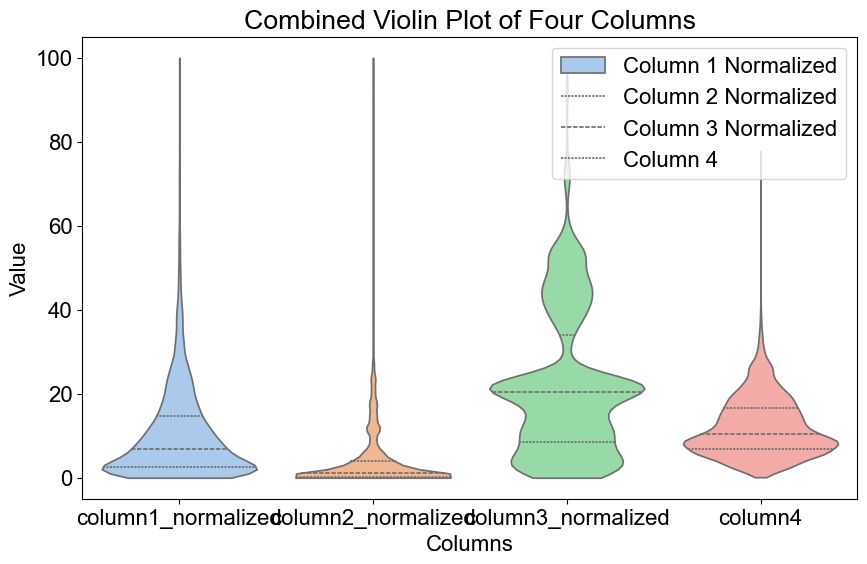

In [326]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# 假设 filtered_df 是您的DataFrame，并且已经包含了您想要绘制的数据
# 这里我们创建一个示例DataFrame
# filtered_df = pd.DataFrame({
#     'column1_normalized': np.random.normal(0, 1, 100),
#     'column2_normalized': np.random.normal(1, 1.5, 100),
#     'column3_normalized': np.random.normal(2, 1, 100),
#     'column4': np.random.normal(3, 2, 100)
# })

# 将四列数据合并为一个列表
data = [filtered_df['column1_normalized'], filtered_df['column2_normalized'], filtered_df['column3_normalized'], filtered_df['column4']/3]

# 设置图形大小
plt.figure(figsize=(10, 6))

# 创建小提琴图
sns.violinplot(data=data, inner="quartile", palette="pastel", cut=0)

# 设置标题和标签
plt.title('Combined Violin Plot of Four Columns')
plt.xlabel('Columns')
plt.ylabel('Value')

# 显示图例
plt.legend(['Column 1 Normalized', 'Column 2 Normalized', 'Column 3 Normalized', 'Column 4'])

# 显示图形
plt.show()

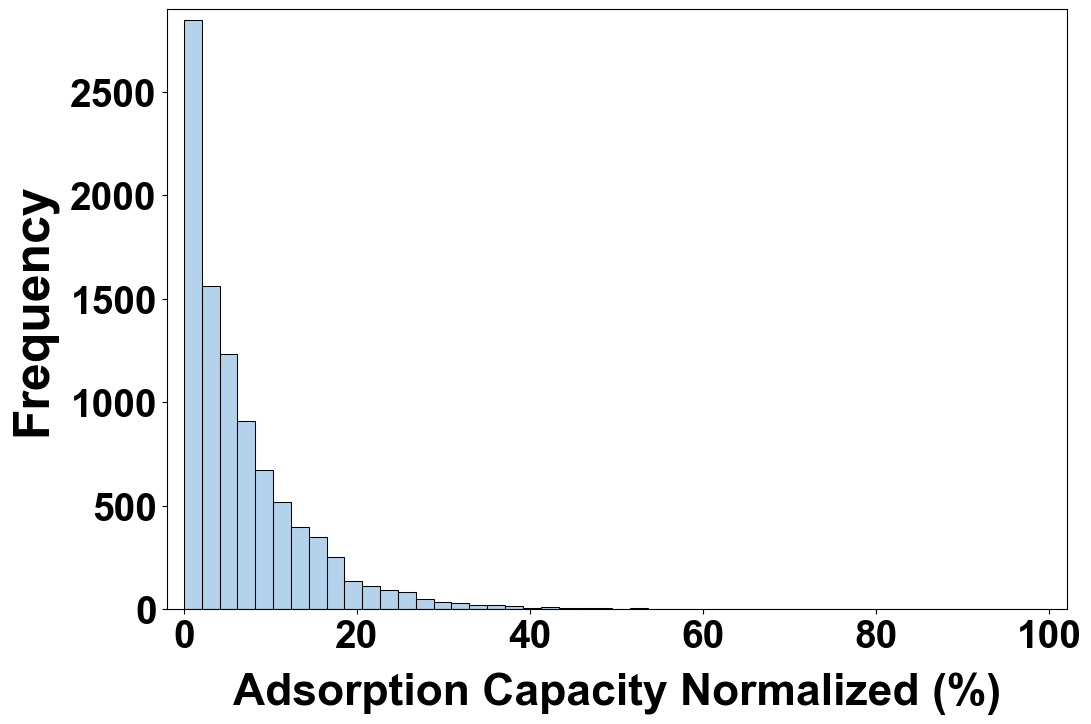

In [25]:
plt.rcParams['font.size'] = 28
plt.rcParams['font.family'] = "Arial"
plt.rcParams['font.style'] = "normal"
plt.rcParams['font.weight'] = "bold"
# 设置图形大小
plt.figure(figsize=(15, 10))

custom_bins = np.linspace(start=0, stop=101, num=50)
plt.subplots_adjust(left=0.2, right=0.8, bottom=0.2, top=0.8, wspace=1, hspace=1)
# 创建子图布局，这里我们创建2行2列的子图
ax1 = plt.subplot(1, 1, 1)


# 绘制第一列的直方图和密度图
yabtc_df = filtered_df[filtered_df['ID'] == 'YABTC']
sns.histplot(filtered_df['column1_normalized'], ax=ax1, color=(157/255,196/255,230/255), bins=custom_bins,linewidth=0.75)
# sns.scatterplot(x=yabtc_df['column1_normalized'], y=50, marker='*', s=800, color=(93/255,132/255,171/255), label='Y-ABTC', ax=ax1)
value = yabtc_df["column1_normalized"].values[0]
rank_percentage = calculate_rank_percentage(value, "column1_normalized")
# ax1.text(value+3, ax1.get_ylim()[1] * 0.7, f'TOP 1.05%', color=(93/255,132/255,171/255), va='top', fontweight="bold",fontsize=36)
# ax1.axvline(x=value, color=(93/255,132/255,171/255), linestyle='--')
# ax1.set_title('Column 1 Normalized Distribution')
ax1.set_xlabel('Adsorption Capacity Normalized (%)', fontsize=32, labelpad=12, fontweight="bold")
ax1.set_ylabel('Frequency', fontsize=36, labelpad=10, fontweight="bold")
ax1.set_xlim(-2, 102)
ax1.set_ylim(0, 2900)

# 保存图形
plt.savefig('histogram1.png', dpi=300, bbox_inches='tight')

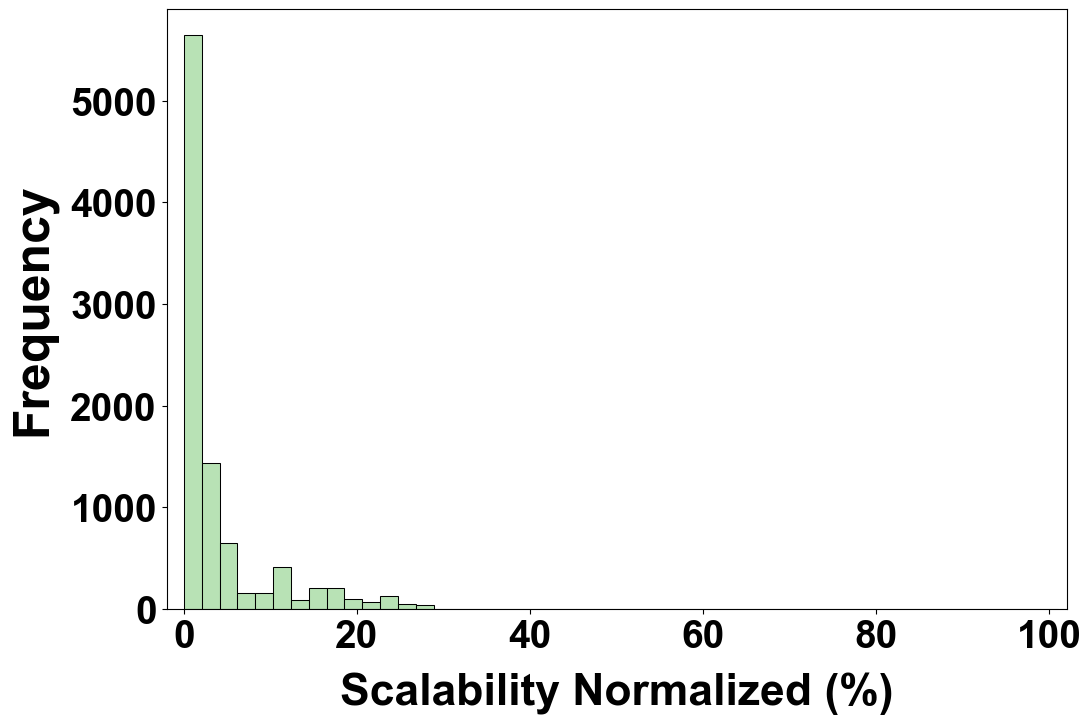

In [33]:
plt.rcParams['font.size'] = 28
plt.rcParams['font.family'] = "Arial"
plt.rcParams['font.style'] = "normal"
plt.rcParams['font.weight'] = "bold"
# 设置图形大小
plt.figure(figsize=(15, 10))

custom_bins = np.linspace(start=0, stop=101, num=50)
plt.subplots_adjust(left=0.2, right=0.8, bottom=0.2, top=0.8, wspace=1, hspace=1)
# 创建子图布局，这里我们创建2行2列的子图
ax1 = plt.subplot(1, 1, 1)


# 绘制第一列的直方图和密度图
yabtc_df = filtered_df[filtered_df['ID'] == 'YABTC']
sns.histplot(filtered_df['column2_normalized'], ax=ax1, color=(161/255,217/255,156/255), bins=custom_bins,linewidth=0.75)
# sns.scatterplot(x=yabtc_df['column2_normalized'], y=100, marker='*', s=800, color="g", label='Y-ABTC', ax=ax1)
# value = yabtc_df["column2_normalized"].values[0]
# rank_percentage = calculate_rank_percentage(value, "column2_normalized")
# ax1.text(value-30, ax1.get_ylim()[1] * 0.7, f'TOP 0.03%', color="g", va='top', fontweight="bold",fontsize=36)
# ax1.axvline(x=value, color="g", linestyle='--')
# ax1.set_title('Column 1 Normalized Distribution')
#ax1.legend(loc='upper center')
ax1.set_xlabel('Scalability Normalized (%)', fontsize=32, labelpad=12, fontweight="bold")
ax1.set_ylabel('Frequency', fontsize=36, labelpad=10, fontweight="bold")
ax1.set_xlim(-2, 102)
ax1.set_ylim(0, 5900)

# 保存图形
plt.savefig('histogram2.png', dpi=300, bbox_inches='tight')

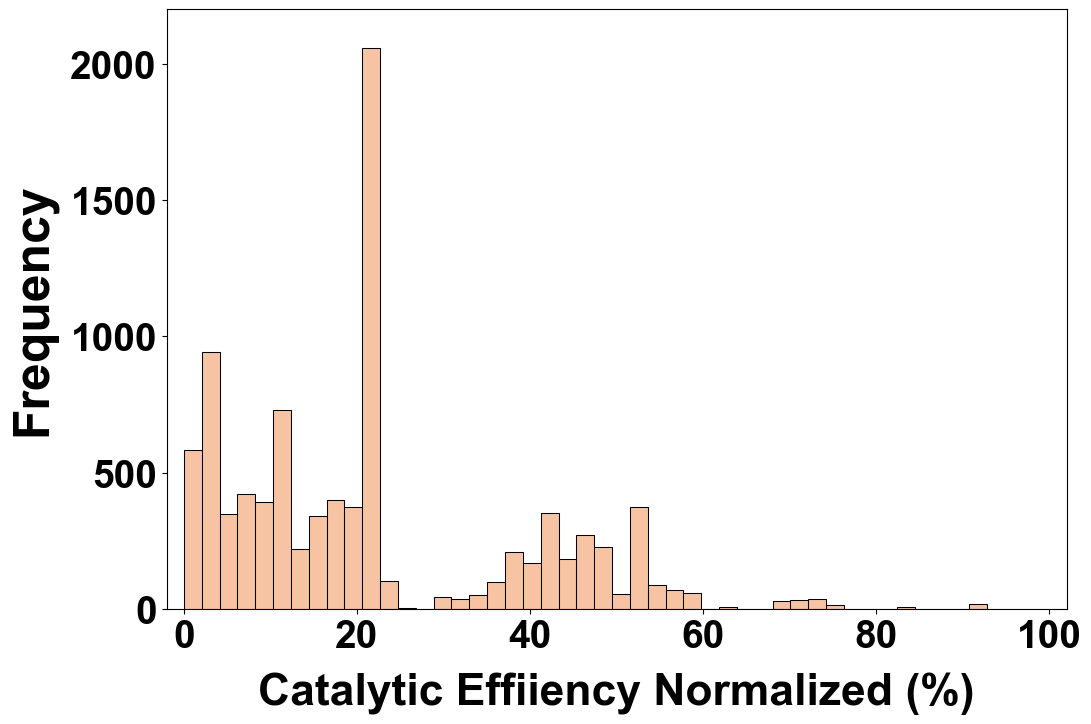

In [34]:
plt.rcParams['font.size'] = 28
plt.rcParams['font.family'] = "Arial"
plt.rcParams['font.style'] = "normal"
plt.rcParams['font.weight'] = "bold"
# 设置图形大小
plt.figure(figsize=(15, 10))

custom_bins = np.linspace(start=0, stop=101, num=50)
plt.subplots_adjust(left=0.2, right=0.8, bottom=0.2, top=0.8, wspace=1, hspace=1)
# 创建子图布局，这里我们创建2行2列的子图
ax1 = plt.subplot(1, 1, 1)


# 绘制第一列的直方图和密度图
yabtc_df = filtered_df[filtered_df['ID'] == 'YABTC']
sns.histplot(filtered_df['column3_normalized'], ax=ax1, color=(244/255,177/255,132/255), bins=custom_bins,linewidth=0.75)
# sns.scatterplot(x=yabtc_df['column3_normalized'], y=50, marker='*', s=800, color=(240/255,141/255,72/255), label='Y-ABTC', ax=ax1)
# value = yabtc_df["column3_normalized"].values[0]
# rank_percentage = calculate_rank_percentage(value, "column3_normalized")
# ax1.text(value+2, ax1.get_ylim()[1] * 0.7, f'TOP 1.22%', color=(240/255,141/255,72/255), va='top', fontweight="bold",fontsize=36)
# ax1.axvline(x=value, color=(240/255,141/255,72/255), linestyle='--')
# ax1.set_title('Column 1 Normalized Distribution')
#ax1.legend(loc='upper center')
ax1.set_xlabel('Catalytic Effiiency Normalized (%)', fontsize=32, labelpad=12, fontweight="bold")
ax1.set_ylabel('Frequency', fontsize=36, labelpad=10, fontweight="bold")
ax1.set_xlim(-2, 102)
ax1.set_ylim(0, 2200)

# 保存图形
plt.savefig('histogram3.png', dpi=300, bbox_inches='tight')

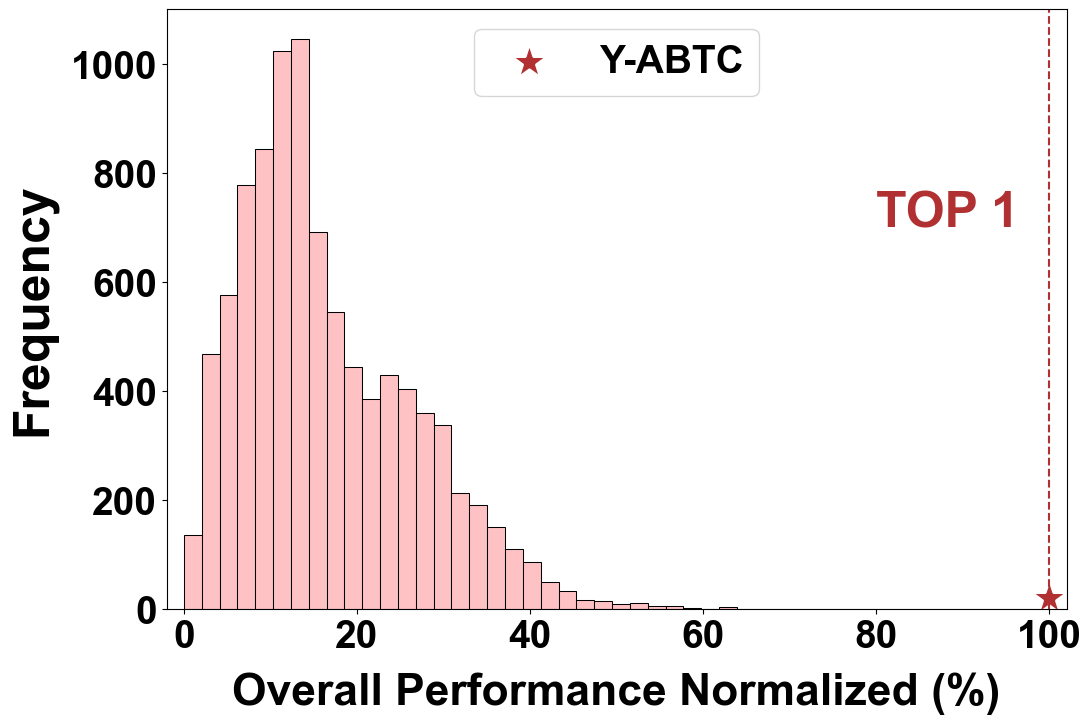

In [29]:
plt.rcParams['font.size'] = 28
plt.rcParams['font.family'] = "Arial"
plt.rcParams['font.style'] = "normal"
plt.rcParams['font.weight'] = "bold"
# 设置图形大小
plt.figure(figsize=(15, 10))

custom_bins = np.linspace(start=0, stop=101, num=50)
plt.subplots_adjust(left=0.2, right=0.8, bottom=0.2, top=0.8, wspace=1, hspace=1)
# 创建子图布局，这里我们创建2行2列的子图
ax1 = plt.subplot(1, 1, 1)


# 绘制第一列的直方图和密度图
yabtc_df = filtered_df[filtered_df['ID'] == 'YABTC']
sns.histplot(filtered_df['column4_normalized'], ax=ax1, color=(255/255,174/255,176/255), bins=custom_bins,linewidth=0.75)
sns.scatterplot(x=yabtc_df['column4_normalized'], y=20, marker='*', s=800, color=(177/255,49/255,51/255), label='Y-ABTC', ax=ax1)
value = yabtc_df["column4_normalized"].values[0]
rank_percentage = calculate_rank_percentage(value, "column4_normalized")
ax1.text(value-20, ax1.get_ylim()[1] * 0.7, f'TOP {rank_percentage}', color=(177/255,49/255,51/255), va='top', fontweight="bold",fontsize=36)
ax1.axvline(x=value, color=(177/255,49/255,51/255), linestyle='--')
# ax1.set_title('Column 1 Normalized Distribution')
ax1.legend(loc='upper center')
ax1.set_xlabel('Overall Performance Normalized (%)', fontsize=32, labelpad=12, fontweight="bold")
ax1.set_ylabel('Frequency', fontsize=36, labelpad=10, fontweight="bold")
ax1.set_xlim(-2, 102)
ax1.set_ylim(0, 1100)

# 保存图形
plt.savefig('histogram4.png', dpi=300, bbox_inches='tight')